<a href="https://colab.research.google.com/github/Vsanku01/Deep-Learning-Tuts/blob/master/OpenCities_Downloading_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [0]:
# Run then restart runtime
!apt-get install python3-rtree
!pip install pystac
!pip install geopandas
!pip install rasterio
!pip install descartes
!pip install solaris
!pip install rio-tiler

In [0]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import solaris as sol
from pathlib import Path
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from rio_tiler import main as rt_main
import skimage
from tqdm import tqdm
import os
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"

# We have to add this wrkaround for stackio:
# (https://pystac.readthedocs.io/en/latest/concepts.html#using-stac-io)
from urllib.parse import urlparse
import requests
from pystac import STAC_IO
def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme.startswith('http'):
        return requests.get(uri).text
    else:
        return STAC_IO.default_read_text_method(uri)
STAC_IO.read_text_method = my_read_method

In [0]:
# Folder Setup
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

img_path = data_dir/'images-256'
mask_path = data_dir/'masks-256'
img_path.mkdir(exist_ok=True)
mask_path.mkdir(exist_ok=True)

# Loading the data

In [0]:
# load our training and test catalogs
train1_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/catalog.json')
train2_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_2/catalog.json')
test_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/test/catalog.json')
cols = {cols.id:cols for cols in train1_cat.get_children()}

In [0]:
# Get a list of the possible areas ('scenes) and ids
areas = []
for c in cols:
  itms = [x for x in cols[c].get_all_items()]
  for i, id in enumerate(itms):
    if i % 2 == 0 and i+1 < len(itms):
      areas.append((c, itms[i].id, itms[i+1].id))
print(areas)

[('acc', '665946', '665946-labels'), ('acc', 'a42435', 'a42435-labels'), ('acc', 'ca041a', 'ca041a-labels'), ('acc', 'd41d81', 'd41d81-labels'), ('mon', '401175', '401175-labels'), ('mon', '493701', '493701-labels'), ('mon', '207cc7', '207cc7-labels'), ('mon', 'f15272', 'f15272-labels'), ('ptn', 'abe1a3', 'abe1a3-labels'), ('ptn', 'f49f31', 'f49f31-labels'), ('kam', '4e7c7f', '4e7c7f-labels'), ('dar', 'a017f9', 'a017f9-labels'), ('dar', 'b15fce', 'b15fce-labels'), ('dar', '353093', '353093-labels'), ('dar', 'f883a0', 'f883a0-labels'), ('dar', '42f235', '42f235-labels'), ('dar', '0a4c40', '0a4c40-labels'), ('znz', '33cae6', '33cae6-labels'), ('znz', '3b20d4', '3b20d4-labels'), ('znz', '076995', '076995-labels'), ('znz', '75cdfa', '75cdfa-labels'), ('znz', '9b8638', '9b8638-labels'), ('znz', '06f252', '06f252-labels'), ('znz', 'c7415c', 'c7415c-labels'), ('znz', 'aee7fd', 'aee7fd-labels'), ('znz', '3f8360', '3f8360-labels'), ('znz', '425403', '425403-labels'), ('znz', 'bd5c14', 'bd5c14-l

# Getting the data into a useful form

Ideally, we'd like images in nice squares with the labels as masks - then we can follow normal image segmentation workflows. Currently, the data is all in a stac. This code takes an area (scene), splits it into tiles at a given zoom level (19 works well to see several buildings) and saves each tile + a mask representing the building fotprints. 

Set greyscale=False to get a 3-channel mask with footprints, outlines and contact areas. 

Apologies for the lack of documentation, but for more info and the source of a lot of this code see 
- https://gist.github.com/daveluo/57ada6ba61ff7c947aad8d6aaeeeb9e4
- https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321

I've also made some of the data available already here: https://www.kaggle.com/johnowhitaker/opencities-masked-256

I'll be working on making a more complete tutorial from start to finish, but I hope this is useful in the meantime.

In [0]:
def save_tile_img(tif_url, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tile, mask = rt_main.tile(tif_url, x,y,z, tilesize=tile_size)
  if display: 
    plt.imshow(np.moveaxis(tile,0,2))
    plt.show()
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.png',np.moveaxis(tile,0,2), check_contrast=False) 

def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False, greyscale=True):
  x,y,z = xyz
  tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
  
  cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
  cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs='epsg:4326')
  
  fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
  if display: plt.imshow(fbc_mask); plt.show()
  
  if greyscale:
    skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask[:,:,0], check_contrast=False) 
  else:
    skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask, check_contrast=False) 

def save_area_id_images(area = 'acc', img_id = 'ca041a', label_id='ca041a-labels', zoom_level = 19, tile_size = 256):

  # The item
  one_item = cols[area].get_item(id=img_id)

  # Load labels shapefile
  lab = cols[area].get_item(id=label_id)
  gdf = gpd.read_file(lab.make_asset_hrefs_absolute().assets['labels'].href)
  # get the geometries from the geodataframe
  all_polys = gdf.geometry

  # Get outlines as polygons
  polygon_geom = Polygon(one_item.to_dict()['geometry']['coordinates'][0])
  polygon = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[polygon_geom])   

  # Tile at zoom_level
  polygon['geometry'].to_file(img_id+'.geojson', driver='GeoJSON')
  !cat {img_id}.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > {img_id}{zoom_level}tiles.geojson

  # Load tiles
  tiles = gpd.read_file(f'{img_id}{zoom_level}tiles.geojson')

  # Add a convenience column
  tiles['xyz'] = tiles.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tiles['xyz'] = [[int(q) for q in p] for p in tiles['xyz']]

  # IMG URL
  tif_url = one_item.assets['image'].href

  # Sometimes it's just ./id.tif - add full path (should maybe use make_asset_hrefs_absolute instead!!)
  if tif_url.startswith("./"):
    tif_url = '/'.join(one_item.to_dict()['links'][1]['href'].split("/")[:-1])+tif_url[1:]

  print("TIF URL:", tif_url)

  print("Number of tiles:", len(tiles))

  # Loop through tiles, downloading and saving
  for idx in range(len(tiles)):
    tile, mask = rt_main.tile(tif_url, *tiles.iloc[idx]['xyz'], tilesize=tile_size)

    tile_poly = tiles.iloc[idx]['geometry']

    # get affine transformation matrix for this tile using rasterio.transform.from_bounds: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds
    tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 

    # crop geometries to what overlaps our tile polygon bounds
    cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
    cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs='epsg:4326')

    # burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html
    fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                            channels=['footprint', 'boundary', 'contact'],
                                            affine_obj=tfm, shape=(tile_size,tile_size),
                                            boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

    save_tile_img(tif_url, tiles.iloc[idx]['xyz'], tile_size, save_path=img_path, prefix=f'{area}_{img_id}_{idx}_', display=False)
    save_tile_mask(all_polys, tile_poly, tiles.iloc[idx]['xyz'], tile_size, save_path=mask_path,prefix=f'{area}_{img_id}_{idx}_', display=False)
    print("Saved", f'{area}_{img_id}_{idx}_')

In [0]:
save_area_id_images(area = 'mon', img_id = 'f15272', label_id='f15272-labels', zoom_level = 19, tile_size = 256)

TIF URL: https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/mon/f15272/f15272.tif
Number of tiles: 86
Saved mon_f15272_0_
Saved mon_f15272_1_
Saved mon_f15272_2_
Saved mon_f15272_3_
Saved mon_f15272_4_
Saved mon_f15272_5_
Saved mon_f15272_6_
Saved mon_f15272_7_
Saved mon_f15272_8_
Saved mon_f15272_9_
Saved mon_f15272_10_
Saved mon_f15272_11_
Saved mon_f15272_12_
Saved mon_f15272_13_
Saved mon_f15272_14_
Saved mon_f15272_15_
Saved mon_f15272_16_
Saved mon_f15272_17_
Saved mon_f15272_18_
Saved mon_f15272_19_
Saved mon_f15272_20_
Saved mon_f15272_21_
Saved mon_f15272_22_
Saved mon_f15272_23_
Saved mon_f15272_24_
Saved mon_f15272_25_
Saved mon_f15272_26_
Saved mon_f15272_27_
Saved mon_f15272_28_
Saved mon_f15272_29_
Saved mon_f15272_30_
Saved mon_f15272_31_
Saved mon_f15272_32_
Saved mon_f15272_33_
Saved mon_f15272_34_
Saved mon_f15272_35_
Saved mon_f15272_36_
Saved mon_f15272_37_
Saved mon_f15272_38_
Saved mon_f15272_39_
Saved mon_f15272_40_
Saved

In [0]:
# TO save for later w drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Compress
!tar -czf my_data.tar.gz data

In [0]:
# copy training data compressed tarball to drive
!cp my_data.tar.gz /content/drive/My\ Drive/ 

# Check that it worked!

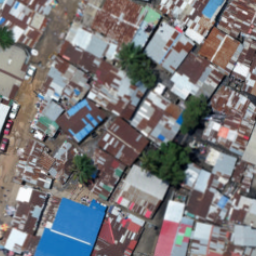

In [0]:
# Pick a random tile
import glob, random
from IPython.display import Image as SHOW_IM
images = glob.glob('data/images-256/*.png')
im = random.choice(images)
SHOW_IM(im)

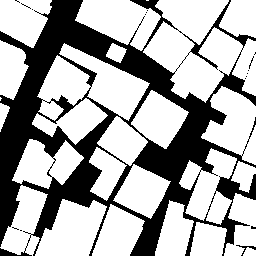

In [0]:
SHOW_IM(im.replace('images', 'masks').replace('.png', '_mask.png')) # The corresponding mask

In [0]:
# You could fetch all the data with:
# for a in areas:
#   save_area_id_images(area = a[0], img_id = a[1], label_id=a[2], zoom_level = 19, tile_size = 256)